In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d jangedoo/utkface-new

 98% 324M/331M [00:01<00:00, 154MB/s]
100% 331M/331M [00:01<00:00, 181MB/s]


In [6]:
import zipfile
ref_zip = zipfile.ZipFile('/content/utkface-new.zip')
ref_zip.extractall('/content')

In [7]:
ref_zip.close()

In [8]:
import os
from keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

In [9]:
file_path = "/content/utkface_aligned_cropped/UTKFace"

In [10]:
age = []
gender = []
image_path = []

for image in os.listdir(file_path):
  age.append(int(image.split('_')[0]))
  gender.append(int(image.split('_')[1]))
  image_path.append(image)

In [11]:
print(age[10])
print(gender[10])
print(image_path[10])

56
0
56_0_0_20170120133932247.jpg.chip.jpg


In [12]:
df = pd.DataFrame()

In [13]:
df['age'] = age
df['gender']= gender
df['image_path'] = image_path

In [14]:
df.head()

,age,gender,image_path
0,24,1,24_1_2_20170116165633882.jpg.chip.jpg
1,27,0,27_0_1_20170116001246691.jpg.chip.jpg
2,35,1,35_1_4_20170116221035151.jpg.chip.jpg
3,38,0,38_0_1_20170113152121359.jpg.chip.jpg
4,64,0,64_0_0_20170111171747624.jpg.chip.jpg


In [15]:
train_data = df.sample(frac=1, random_state=0).iloc[:20000]
test_data = df.sample(frac=1, random_state=0).iloc[20000:]

In [16]:
train_data

,age,gender,image_path
15426,44,0,44_0_3_20170119195144674.jpg.chip.jpg
14084,48,0,48_0_1_20170113184623503.jpg.chip.jpg
22319,26,0,26_0_2_20170116181346232.jpg.chip.jpg
19518,24,0,24_0_4_20170115205946148.jpg.chip.jpg
2255,35,0,35_0_4_20170116191747403.jpg.chip.jpg
...,...,...,...
3702,29,0,29_0_4_20170117180903787.jpg.chip.jpg
18478,29,1,29_1_1_20170112210246493.jpg.chip.jpg
9096,28,0,28_0_0_20170116174356539.jpg.chip.jpg
10613,65,0,65_0_0_20170117162901325.jpg.chip.jpg


In [17]:
print(type(test_data))
test_data

<class 'pandas.core.frame.DataFrame'>


,age,gender,image_path
9293,35,0,35_0_2_20170116191807393.jpg.chip.jpg
7515,80,0,80_0_0_20170117174755679.jpg.chip.jpg
53,28,1,28_1_1_20170116223115624.jpg.chip.jpg
6395,1,0,1_0_2_20161219203720956.jpg.chip.jpg
21250,1,0,1_0_2_20161219205016902.jpg.chip.jpg
...,...,...,...
13123,25,1,25_1_1_20170113001625270.jpg.chip.jpg
19648,1,1,1_1_2_20161219221241583.jpg.chip.jpg
9845,24,1,24_1_0_20170117150424339.jpg.chip.jpg
10799,49,0,49_0_1_20170113142200613.jpg.chip.jpg


In [18]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    height_shift_range=0.2,
    width_shift_range=0.2,
    horizontal_flip=True,
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    train_data,
    directory=file_path,
    x_col = 'image_path',
    y_col = ['age', 'gender'],
    target_size = [200,200],
    class_mode = 'multi_output'
)

test_generator = test_datagen.flow_from_dataframe(
    test_data,
    directory=file_path,
    x_col = 'image_path',
    y_col = ['age', 'gender'],
    target_size = [200,200],
    class_mode = 'multi_output'
)

Found 20000 validated image filenames.
Found 3708 validated image filenames.


In [20]:
from keras.applications.vgg16 import VGG16
from keras.layers import *
from keras.models import Model

In [21]:
vgg_model = VGG16(include_top=False, input_shape=(200,200,3))

58889256/58889256 [==============================] - 0s 0us/step


In [22]:
vgg_model.trainable = False

In [23]:
vgg_model.layers[-1]

In [24]:
output = vgg_model.layers[-1].output

In [25]:
type(output)

keras.src.engine.keras_tensor.KerasTensor

In [26]:
flatten = Flatten()(output)

In [27]:
dense1 = Dense(512, activation='relu')(flatten)
dense2 = Dense(512, activation='relu')(flatten)

dense3 = Dense(256, activation='relu')(dense1)
dense4 = Dense(256, activation='relu')(dense2)

age_output  = Dense(1, activation='linear', name='age')(dense3)
gender_output  = Dense(1, activation='sigmoid', name='gender')(dense4)

In [28]:
model = Model(inputs=vgg_model.input, outputs=[age_output, gender_output])

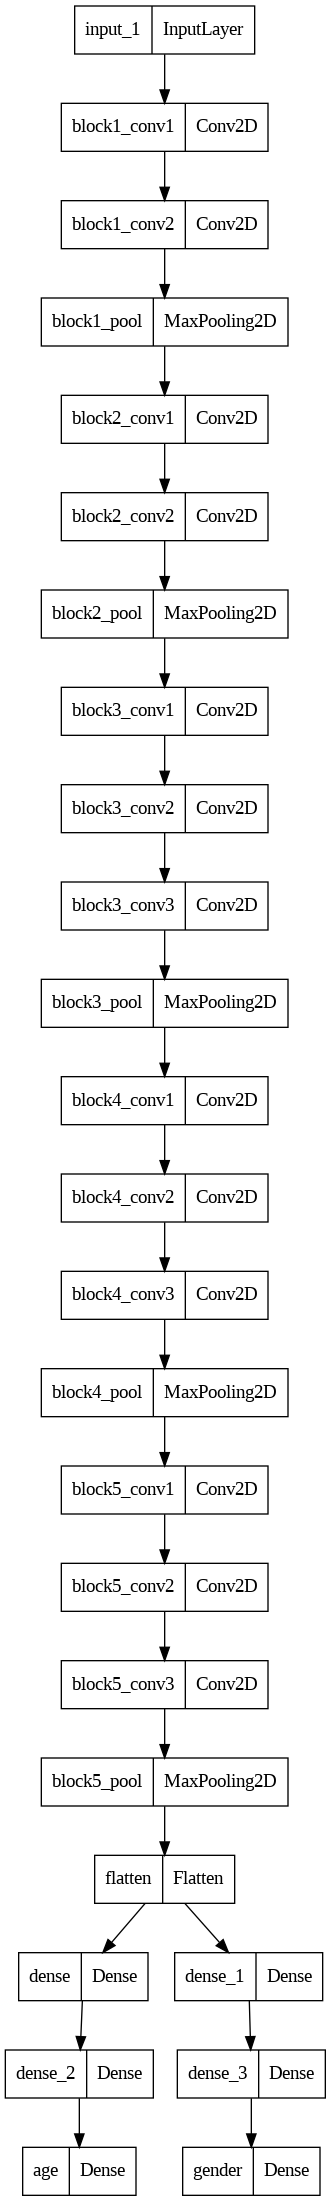

In [29]:
from keras.utils import plot_model
plot_model(model)

In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 200, 200, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 200, 200, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)         0         ['block1_conv2[0][0]']        
                                                                                              

In [31]:
model.compile(optimizer='adam', loss={'age':'mae', 'gender':'binary_crossentropy'},metrics={'age':'mae', 'gender':'accuracy'}, loss_weights={
    'age':1, 'gender':99
})

In [32]:
history = model.fit(train_generator,batch_size=32, validation_data=test_generator, validation_batch_size=16, epochs=8)

Epoch 1/8
625/625 [==============================] - 260s 397ms/step - loss: 65.5217 - age_loss: 10.8246 - gender_loss: 0.5525 - age_mae: 10.8246 - gender_accuracy: 0.7304 - val_loss: 45.0266 - val_age_loss: 8.8394 - val_gender_loss: 0.3655 - val_age_mae: 8.8394 - val_gender_accuracy: 0.8296
Epoch 2/8
625/625 [==============================] - 244s 390ms/step - loss: 53.3074 - age_loss: 9.2339 - gender_loss: 0.4452 - age_mae: 9.2339 - gender_accuracy: 0.7871 - val_loss: 50.3490 - val_age_loss: 9.2448 - val_gender_loss: 0.4152 - val_age_mae: 9.2448 - val_gender_accuracy: 0.8139
Epoch 3/8
625/625 [==============================] - 245s 392ms/step - loss: 50.5395 - age_loss: 9.0706 - gender_loss: 0.4189 - age_mae: 9.0706 - gender_accuracy: 0.8062 - val_loss: 40.9885 - val_age_loss: 8.5768 - val_gender_loss: 0.3274 - val_age_mae: 8.5768 - val_gender_accuracy: 0.8503
Epoch 4/8
625/625 [==============================] - 242s 388ms/step - loss: 49.1743 - age_loss: 8.8634 - gender_loss: 0.4072

In [33]:
type(history)

keras.src.callbacks.History

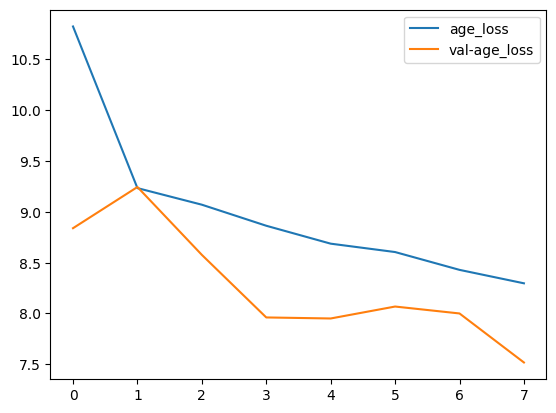

In [37]:
plt.plot(history.history['age_loss'], label='age_loss')
plt.plot(history.history['val_age_loss'], label ='val-age_loss')
plt.legend()

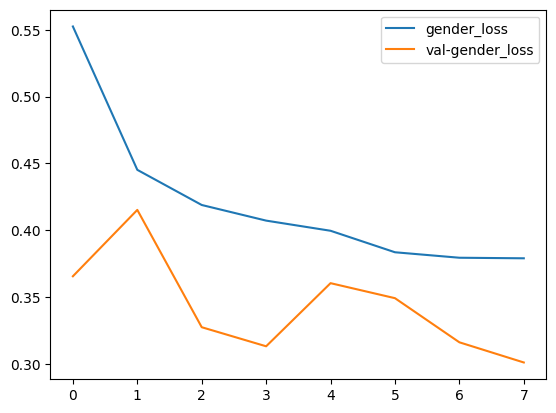

In [38]:
plt.plot(history.history['gender_loss'], label='gender_loss')
plt.plot(history.history['val_gender_loss'], label ='val-gender_loss')
plt.legend()

# both are decreasing as number of epochs increases

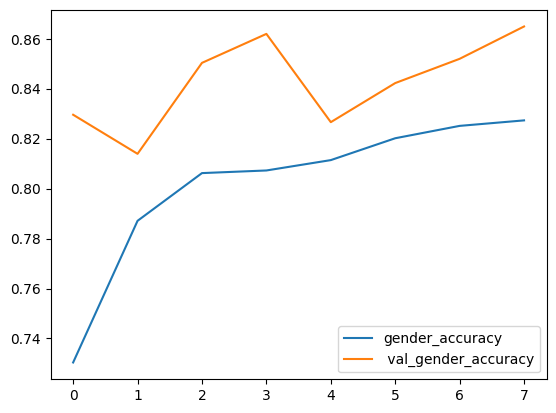

In [39]:
plt.plot(history.history['gender_accuracy'], label='gender_accuracy')
plt.plot(history.history['val_gender_accuracy'], label =' val_gender_accuracy')
plt.legend()

# both are increasing as number of epochs increases --->> model is good

In [40]:
import pickle
pickle.dump(model,open('model.pkl','wb'))

In [41]:
import cv2

In [100]:
image = cv2.imread('/content/UTKFace/10_1_0_20170109203501969.jpg.chip.jpg')

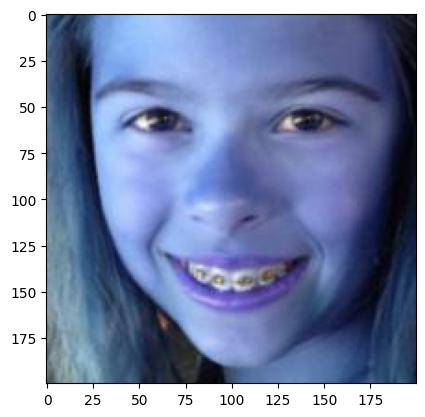

In [101]:
plt.imshow(image)

In [102]:
image = cv2.resize(image, (200,200))
image = image.reshape((1,200,200,3))

In [103]:
max = np.max(image)
min = np.min(image)

In [104]:
image = (image-min)/max-min

In [106]:
model.predict(image)[1][0][0]

1/1 [==============================] - 0s 28ms/step


0.9859768

In [115]:
def  prediction(image):
  image = cv2.resize(image, (200,200))
  plt.imshow(image)
  image = (image-min)/(max-min)

  image = image.reshape((1,200,200,3))
  y_hat = model.predict(image)
  age = y_hat[0][0][0]
  gender = y_hat[1][0][0]

  if(gender>=0.5):
    print("The gender of the image in picture is: Female")
    print('Age of the person is :', age)
  else:
    print("The gender of the image in picture is: Male")
    print('Age of the person is :', age)


1/1 [==============================] - 0s 20ms/step
The gender of the image in picture is: Female
Age of the person is : 10.643252


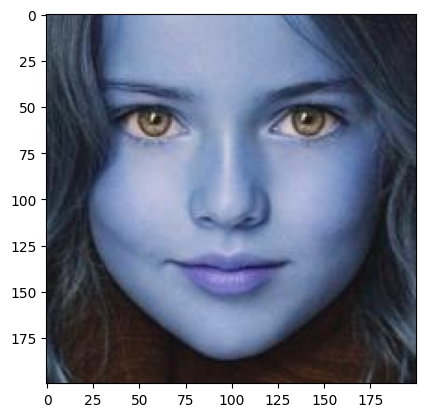

In [116]:
image = cv2.imread('/content/UTKFace/10_1_0_20170109203438428.jpg.chip.jpg')
prediction(image)

1/1 [==============================] - 0s 18ms/step
The gender of the image in picture is: Male
Age of the person is : 23.638721


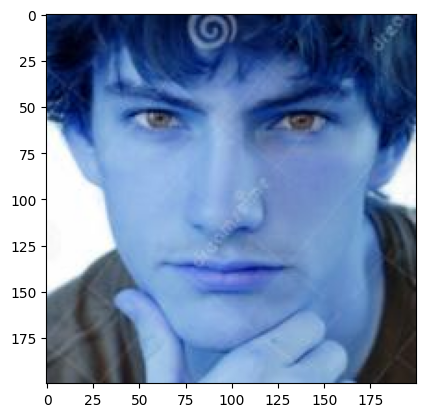

In [117]:
image = cv2.imread('/content/UTKFace/16_0_0_20170110231647962.jpg.chip.jpg')
prediction(image)

1/1 [==============================] - 0s 32ms/step
The gender of the image in picture is: Male
Age of the person is : 68.44648


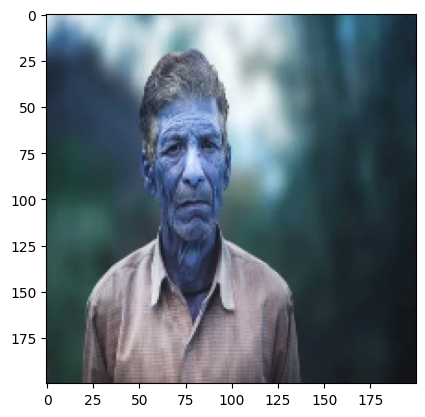

In [121]:
image = cv2.imread('/content/portrait-of-an-old-indian-man.jpg')
prediction(image)

1/1 [==============================] - 0s 33ms/step
The gender of the image in picture is: Male
Age of the person is : 36.904617


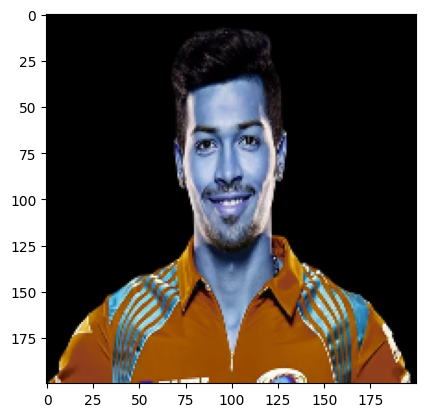

In [122]:
image = cv2.imread('/content/wp4001288.jpg')
prediction(image)